<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Max_BentU4Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Project: Projecting MLB Bat Speed by Position

I decided to work with baseball data again, what a surprise. This time, I'm using average bat speed data from this past MLB season broken up by position. Bat speed data only started to be tracked publicly this year, so the 2024 season is the only one we can use.

## Setup + initial data thoughts



Let's import some libraries:

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [3]:
# colab add preliz by default challenge (impossible)

!pip install preliz
import preliz as pz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


And our dataset(s).

In [7]:
# all players with at least 200 "competitive swings" sorted alphabetically, with their average bat speed
# why 200? because only including "qualified" players (500) would leave out most backup players and utilitymen
bat_1 = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/bat-tracking.csv')

# player positions
player_pos = pd.read_csv('https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/mlb-player-stats-Batters.csv')

As far as I can tell, Statcast (the repository for bat speed, as well as related statistics like launch angle, pitch velocity and exit velocity) does not list player positions in their datasets (and anywhere except the player pages, which would be a pain in the ass to compile, manually or by automation through web scraping), so I found another dataset that does have them to combine it with.

In [8]:
# merges the two datasets using an inner join, a SQL-derived function that combines two databases based on shared values
bat_fixed = pd.merge(player_pos, bat_1, on='name', how='inner')
bat_fixed

,pos,name,avg_bat_speed
0,SS,"Abrams, CJ",72.245374
1,OF,"Abreu, Wilyer",74.554859
2,SS,"Adames, Willy",73.615644
3,C,"Adams, Riley",75.517763
4,OF,"Adell, Jo",76.674033
...,...,...,...
414,OF,"Yastrzemski, Mike",70.946955
415,OF,"Yelich, Christian",73.174690
416,1B,"Yepez, Juan",70.480310
417,DH,"Yoshida, Masataka",70.944681


Here's the moments of the group by position, as well as a KDE plot:

In [ ]:
bat_fixed.groupby("pos")["avg_bat_speed"].mean() # mean by position

,avg_bat_speed
pos,
1B,70.903207
2B,69.777282
3B,71.051814
C,71.205470
DH,73.479889
OF,71.683360
SS,70.332299


In [ ]:
bat_fixed.groupby("pos")["avg_bat_speed"].skew() # skew by position

,avg_bat_speed
pos,
1B,-0.749262
2B,-0.290549
3B,0.381157
C,0.039788
DH,0.956874
OF,0.089373
SS,0.053725


In [ ]:
bat_fixed.groupby("pos")["avg_bat_speed"].std() # std. dev by position

,avg_bat_speed
pos,
1B,3.269332
2B,2.872906
3B,2.665736
C,2.261644
DH,3.403146
OF,2.460408
SS,2.630513


In [ ]:
bat_fixed.groupby("pos")["avg_bat_speed"].apply(pd.Series.kurt) # kurtosis by position

,avg_bat_speed
pos,
1B,-0.047678
2B,0.041809
3B,-0.394070
C,-0.446186
DH,0.955051
OF,0.384051
SS,-0.461279


<Axes: xlabel='avg_bat_speed', ylabel='Density'>

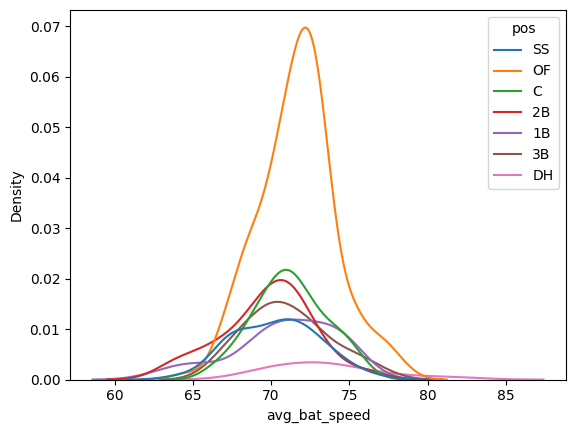

In [ ]:
sns.kdeplot(data=bat_fixed, x="avg_bat_speed", hue='pos') # kde plot

<Axes: xlabel='avg_bat_speed'>

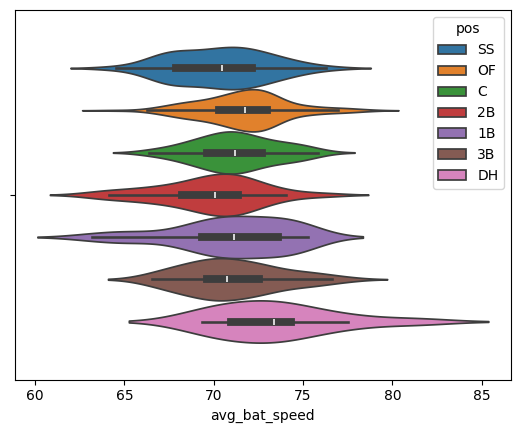

In [ ]:
sns.violinplot(data=bat_fixed, x="avg_bat_speed", hue="pos")

As we can see now, there are 7 possible positions that players fall into. By far the most common is "OF", which is explained by the fact that they are really three different positions rolled into one: left field, center field and right field. The least common, also by a pretty clear margin, is "DH", which is because "true" DHs are relatively uncommon, as most of the time they split their time between DHing and easier fielding positions like first base or corner outfield instead.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) The remaining five positions are all relatively similar in quantity.

I think this is a pretty interesting list of distributions. Prior to looking at the data, I would have guessed that the differences would be more stark, and while some positions seem to have more sluggers than others (namely OF and DH  have more positively-skewed tails than 3B or SS), everything seems to be clustered around 71mph or so. There is some distribution among the means--2B's mean is a little under 69, while DH's is around 73.5--but it's a pretty small difference.

## Attempt 1

For my first attempt, I'll use a skewed Student-T for my likelihood because each position varies somewhat in its skewness<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2), with the tails (or "kurtosis") varying in their size, which would be ripe for a skewed Student-T distribution.

I'll use a SkewNormal for the location parameter (mu) since the distribution of means looks positively skewed. This looks pretty similar for each position, so I won't use any hyperpriors for this part of the model.

For the scale parameter (sigma), I'll use a regular Normal. This is because there doesn't seem to be much variance in the standard deviation of each group, which is also why I'm not going to have any hyperpriors for this part.

For the two shape parameters, I'll go with one Gamma for A and B, with two shared Normals for the alpha/beta parameters. The a and b parameters should vary depending on the position (sometimes a > b, sometimes a, b are lower, etc) so two Normals for the Gamma distribution makes sense, as a and b are likely going to be low values and positively skewed slightly. I am the least confident about this one, mainly because I have no idea if using the same prior distribution for two different parameters will make the model shoot itself or not.

<Axes: >

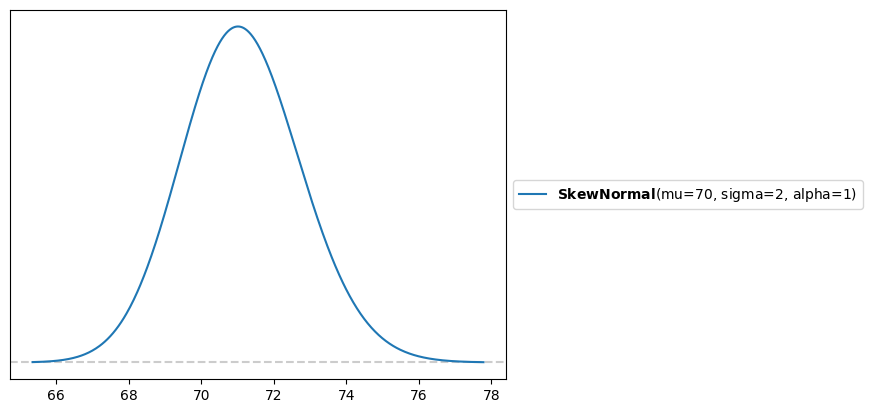

In [ ]:
# location parameter/mu
pz.SkewNormal(mu = 70, sigma = 2, alpha = 1).plot_pdf()

<Axes: >

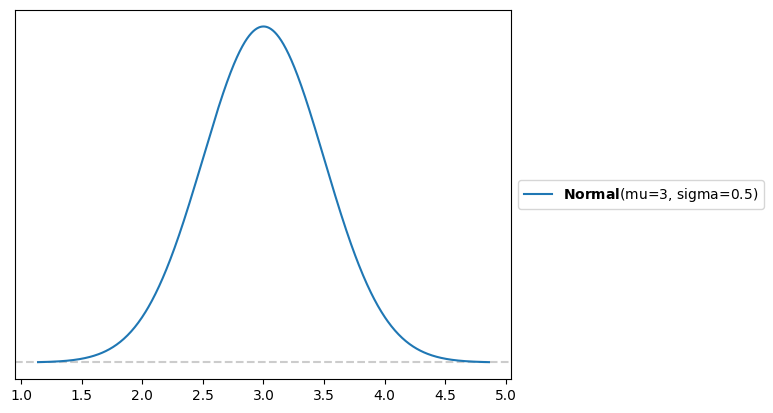

In [ ]:
# scale parameter/sigma
pz.Normal(mu = 3, sigma = 0.5).plot_pdf()

<Axes: >

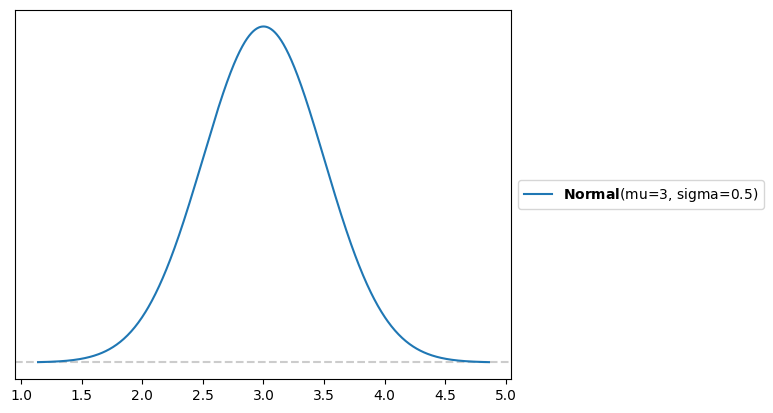

In [ ]:
# the two hyperpriors (alpha)
pz.Normal(mu = 3, sigma = 0.5).plot_pdf()

<Axes: >

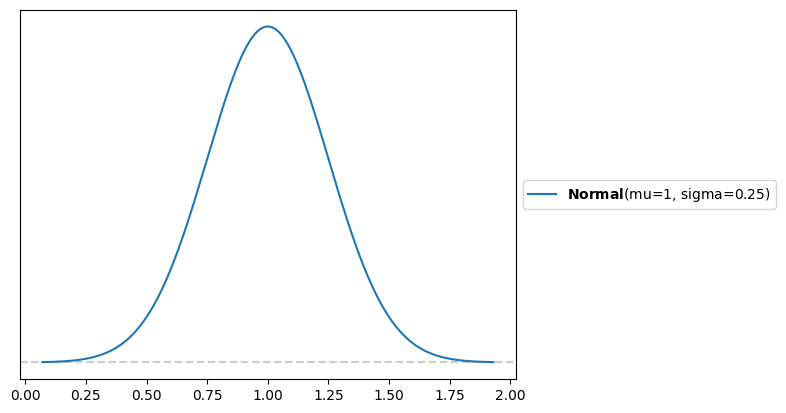

In [ ]:
# hyperprior beta
pz.Normal(mu = 1, sigma = 0.25).plot_pdf()

<Axes: >

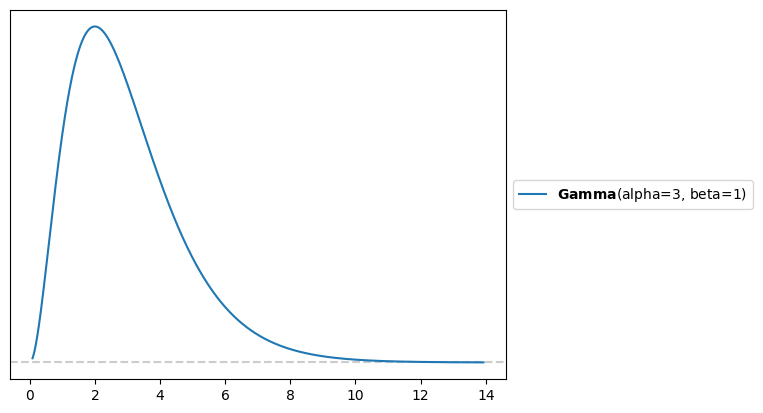

In [ ]:
# not gonna be the final distribution, but to give you an intuition for what a Gamma looks like
pz.Gamma(alpha = 3, beta = 1).plot_pdf()

<Axes: >

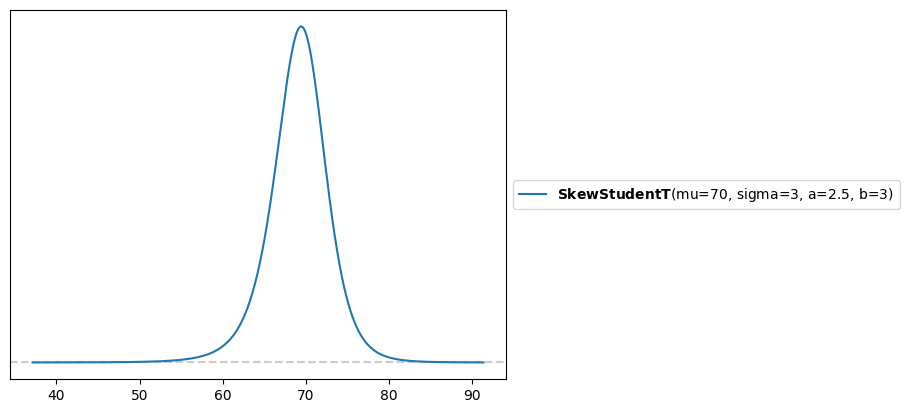

In [ ]:
# same as above but for the likelihood
pz.SkewStudentT(mu = 70, sigma = 3, a = 2.5, b = 3).plot_pdf()

In [9]:
# more dataset wrangling

#Turns the position column into a categorical variable
bat_fixed['pos'] = bat_fixed['pos'].astype('category')

#this is an array of the positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = bat_fixed.pos.cat.codes.values

#an array of the four strings that represent position
pos_codes = bat_fixed.pos.cat.categories

#puts coords in a dict, so pymc can read them
bspeed_coords = {"pos": pos_codes}

In [10]:
# model

with pm.Model(coords=bspeed_coords) as bspeed_model1:

  # hyperpriors for a, b
  a_b_alpha = pm.Normal('ab_alpha', mu=3, sigma=0.5) # alpha parameter of gamma
  a_b_beta = pm.Normal('ab_beta', mu = 1, sigma = 0.25) # beta parameter of gamma

  # priors
  mu = pm.SkewNormal('mu', mu = 70, sigma = 2, alpha = 1, dims='pos') # mean
  sigma = pm.Normal('sigma', mu = 3, sigma = 0.5, dims='pos') # std. dev
  a = pm.Gamma('a', alpha = a_b_alpha, beta = a_b_beta, dims='pos') # a
  b = pm.Gamma('b', alpha = a_b_alpha, beta = a_b_beta, dims='pos') # b

  # likelihood
  pm.SkewStudentT('y', mu = mu[pos_idx], sigma = sigma[pos_idx], a = a[pos_idx], b = b[pos_idx], observed=bat_fixed.avg_bat_speed.values) # the big boy

  # posterior sampling
  bat_post1 = pm.sample(target_accept = 0.95)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f33da36ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

No divergences, yay! I had 54 (???) divergences on one of the chains the first time I ran it, so I increased the target_accept.

Here's the r-hat and plot trace info, as well as a graphviz.

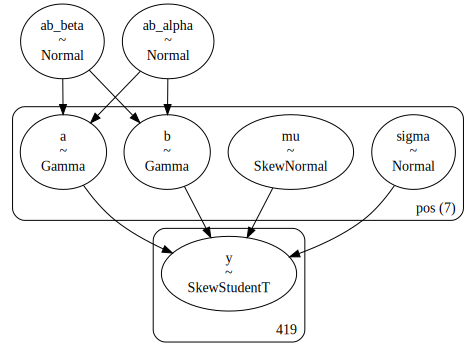

In [ ]:
# graph viz of model
pm.model_to_graphviz(bspeed_model1)

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'ab_alpha'}>,
        <Axes: title={'center': 'ab_alpha'}>],
       [<Axes: title={'center': 'ab_beta'}>,
        <Axes: title={'center': 'ab_beta'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

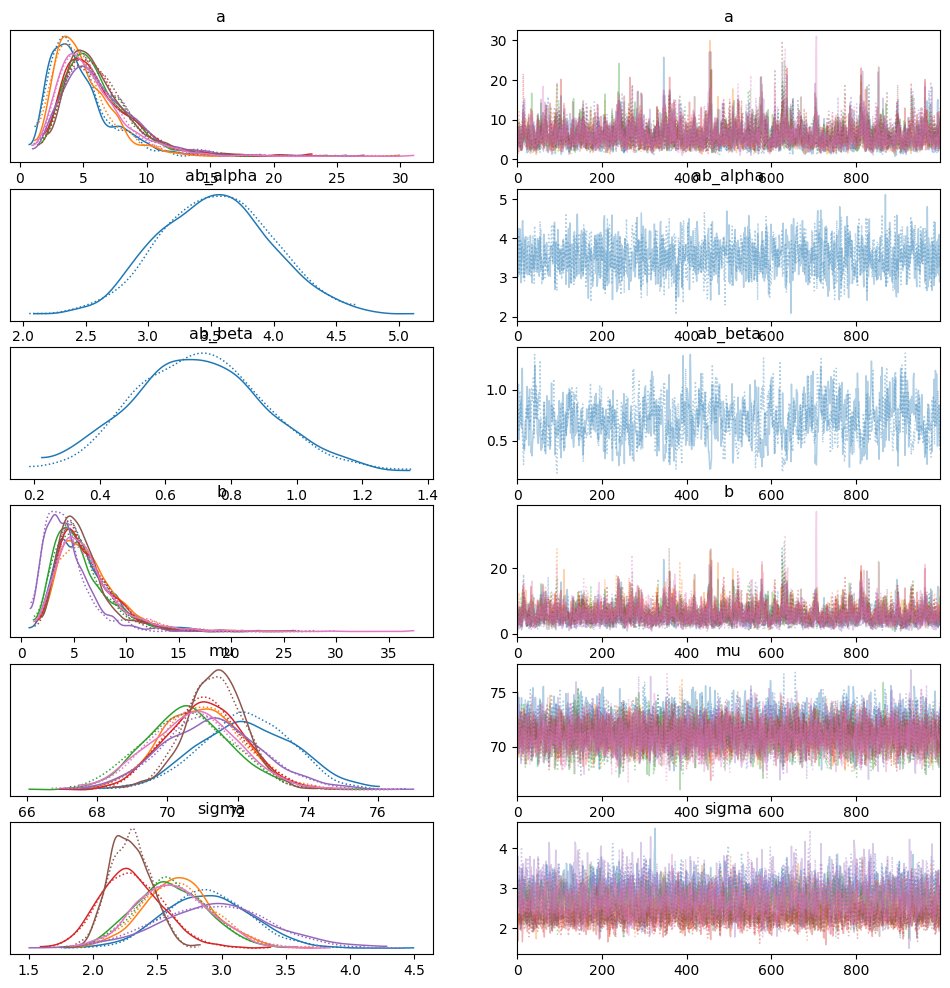

In [ ]:
# chains
az.plot_trace(bat_post1)

In [ ]:
# find rhat
az.rhat(bat_post1)

<xarray.Dataset> Size: 296B
Dimensions:   (pos: 7)
Coordinates:
  * pos       (pos) <U2 56B '1B' '2B' '3B' 'C' 'DH' 'OF' 'SS'
Data variables:
    a         (pos) float64 56B 1.006 1.004 1.002 1.003 1.001 1.002 1.002
    ab_alpha  float64 8B 1.001
    ab_beta   float64 8B 1.005
    b         (pos) float64 56B 1.003 1.003 1.003 1.004 1.002 1.003 1.002
    mu        (pos) float64 56B 1.002 1.002 1.001 1.001 1.003 1.0 0.9997
    sigma     (pos) float64 56B 1.001 1.002 1.0 1.001 1.0 1.001 1.0

This looks pretty good, I'm gonna be honest. The chains don't look half bad. The r-hat values aren't spectacular by any means, but they're pretty good. Let's see how the final distribution looks:

In [11]:
# posterior predictive sampling

pm.sample_posterior_predictive(bat_post1, model=bspeed_model1, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

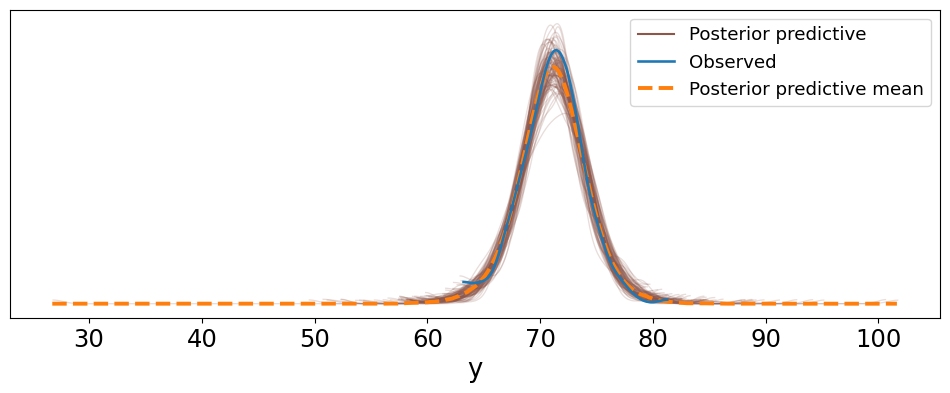

In [ ]:
# plot posterior predictive (colors changed to see the mean more clearly)
az.plot_ppc(bat_post1, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C0", "C1"])

I think this is pretty good. The shape is very close on the upswing and downswing (especially on the left side), albeit with a caveat of the peak being slightly less accurate to the data. Overall, I think this is pretty good.

Let's take a more detailed look at the different parameters.

array([<Axes: >], dtype=object)

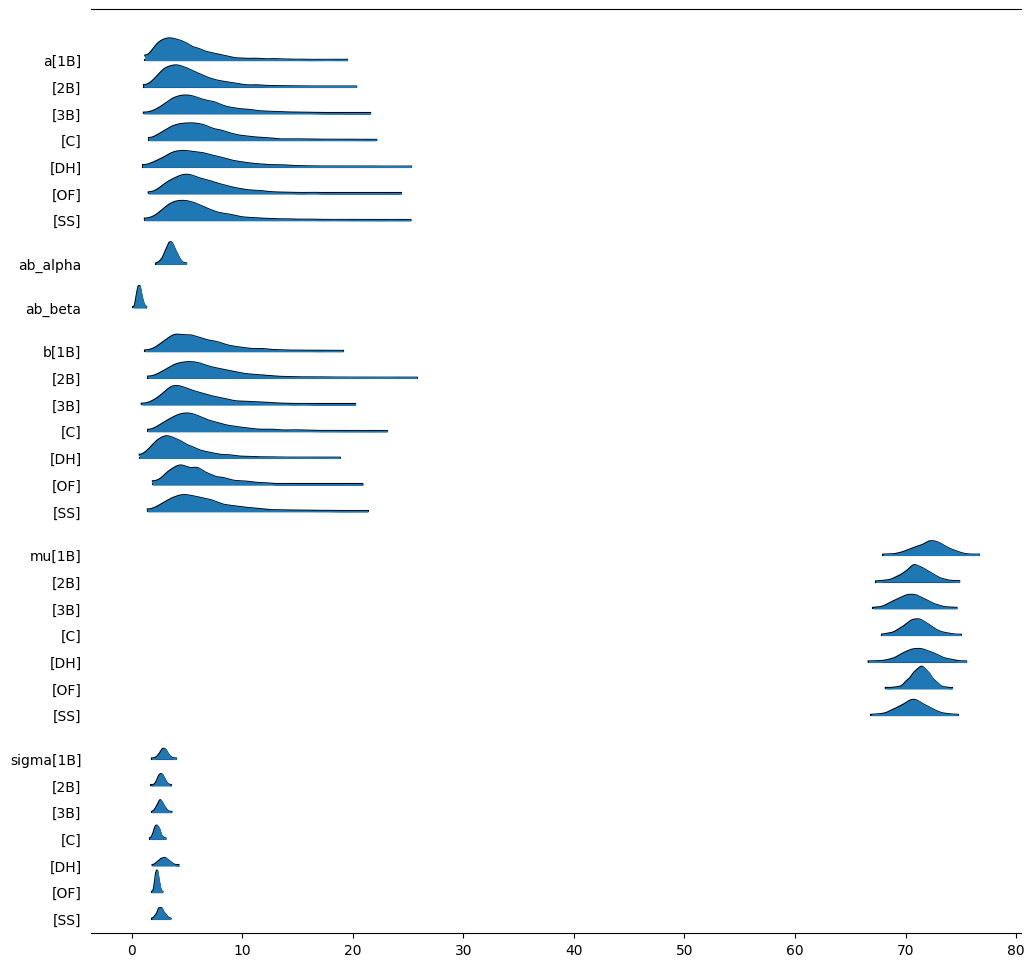

In [13]:
# forest plot of all the parameters

az.plot_forest(bat_post1, combined=True, figsize=(12, 12), kind = 'ridgeplot', hdi_prob=0.998)

Surprisingly, the shared prior for both a and b seemed to have worked! As I predicted, it looks as if the distributions for the shape parameters for DH would indicate a more positive skew, as a is (generally) greater than b, and the distributions for 2B's shape parameters indicated a more negative skew, as b is (somewhat) greater than b, although my brain could just be messing with me.

I'm honestly really happy with this! But it might still be possible to improve it. Let's see what else we can do.

## Attempt 2

I'm gonna try to use a regular Student-T this time, mainly just because I want to see what happens if we assume the skew is independent of one another, as the kurtosis seemed to be the main difference between groups. I will keep the mu and sigma parameters the same, as they seemed to work pretty well in the previous model.

For the nu parameter (kurtosis), I'll use an Exponential, with a Gamma hyperprior of very low values.

<Axes: >

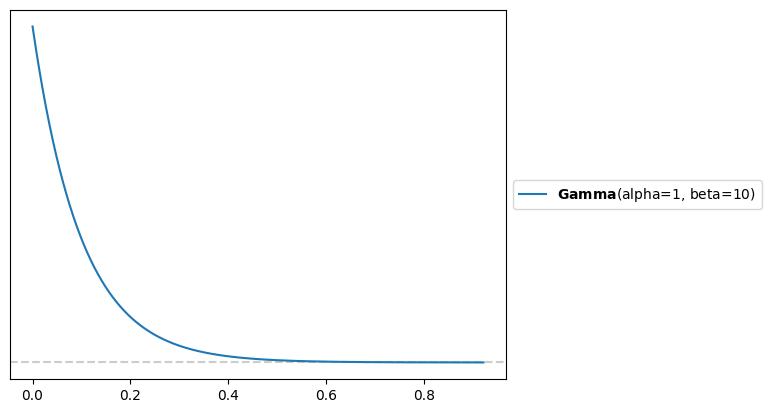

In [ ]:
# lambda for the nu
pz.Gamma(alpha = 1, beta = 10).plot_pdf()

<Axes: >

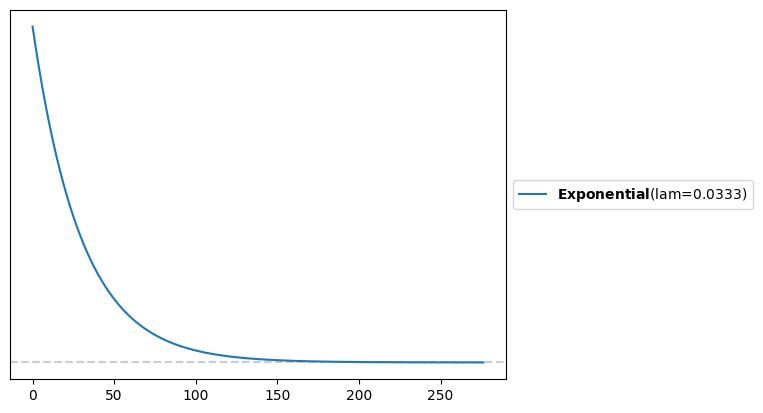

In [ ]:
# here's what an exponential looks like
pz.Exponential(lam = 1/30).plot_pdf()

<Axes: >

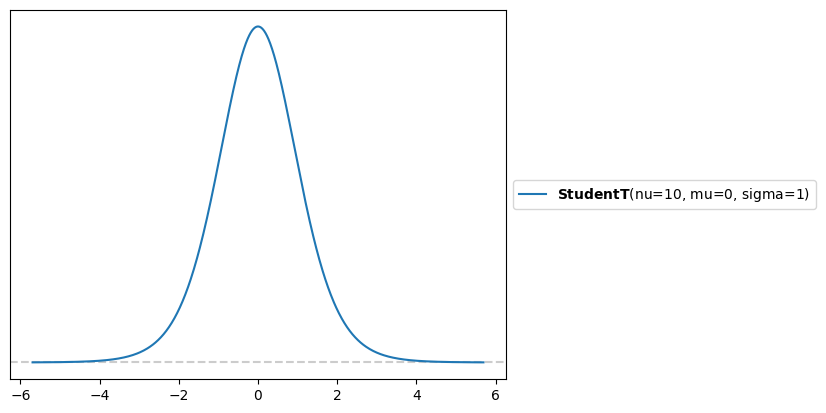

In [ ]:
# here's what a regular Student-T looks like
pz.StudentT(mu = 0, sigma = 1, nu = 10).plot_pdf()

In [20]:
# model 2

with pm.Model(coords=bspeed_coords) as bspeed_model2:

  # hyperpriors for mu, sigma
  nu_lambda = pm.Gamma('nu_lambda', alpha = 1, beta = 10) # lambda parameter of exponential

  # priors
  mu = pm.SkewNormal('mu', mu = 70, sigma = 2, alpha = 1, dims='pos') # mean
  sigma = pm.Normal('sigma', mu = 3, sigma = 0.5, dims='pos') # std. dev
  nu = pm.Exponential('nu', lam = nu_lambda, dims='pos') # kurtosis

  # likelihood
  pm.StudentT('y', mu = mu[pos_idx], sigma = sigma[pos_idx], nu = nu[pos_idx], observed=bat_fixed.avg_bat_speed.values) # the big boy

  # posterior sampling
  bat_post2 = pm.sample(target_accept = 0.95)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f33d9284790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

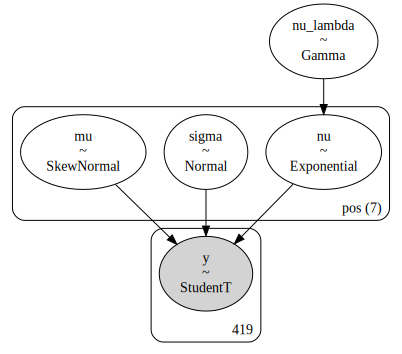

In [ ]:
# graph viz of hierarchy
pm.model_to_graphviz(bspeed_model2)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'nu'}>, <Axes: title={'center': 'nu'}>],
       [<Axes: title={'center': 'nu_lambda'}>,
        <Axes: title={'center': 'nu_lambda'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

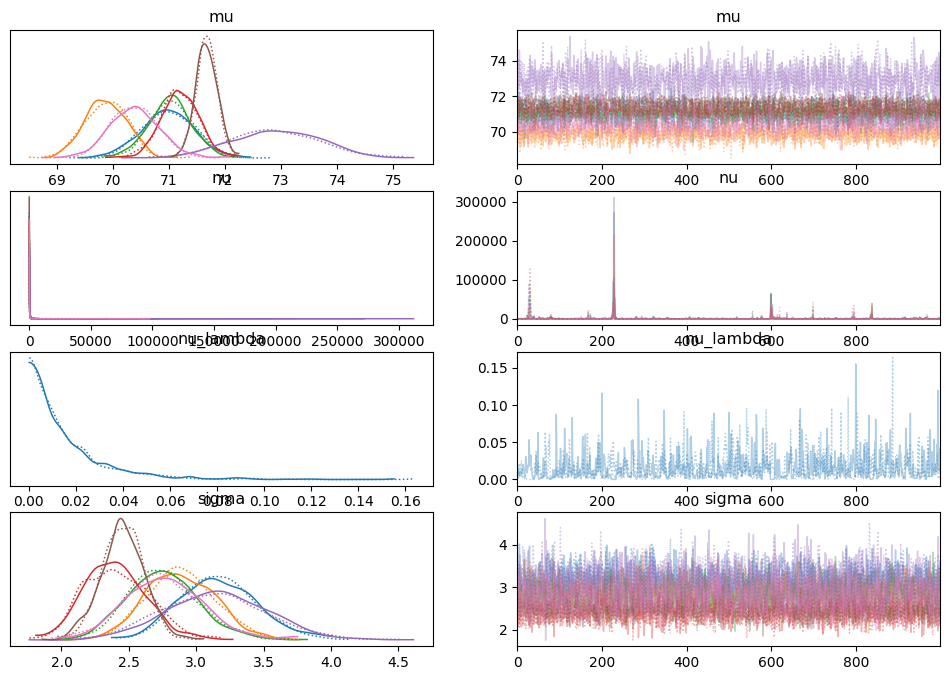

In [ ]:
# chains
az.plot_trace(bat_post2)

In [ ]:
# find rhat
az.rhat(bat_post2)

<xarray.Dataset> Size: 232B
Dimensions:    (pos: 7)
Coordinates:
  * pos        (pos) <U2 56B '1B' '2B' '3B' 'C' 'DH' 'OF' 'SS'
Data variables:
    mu         (pos) float64 56B 1.001 1.002 1.001 1.0 0.9996 1.0 1.0
    nu         (pos) float64 56B 1.004 1.003 1.002 1.003 1.003 1.005 1.001
    nu_lambda  float64 8B 1.006
    sigma      (pos) float64 56B 1.001 1.001 1.002 1.001 1.0 1.002 1.0

I honestly don't really know what to make of this. The lambda chains look extremely weird, as there's extremely high spikes to 300,000(!!), but the r-hats look fine, even better than the skewed student-T model.

Let's see what's up with the posterior:

Output()

<Axes: xlabel='y'>

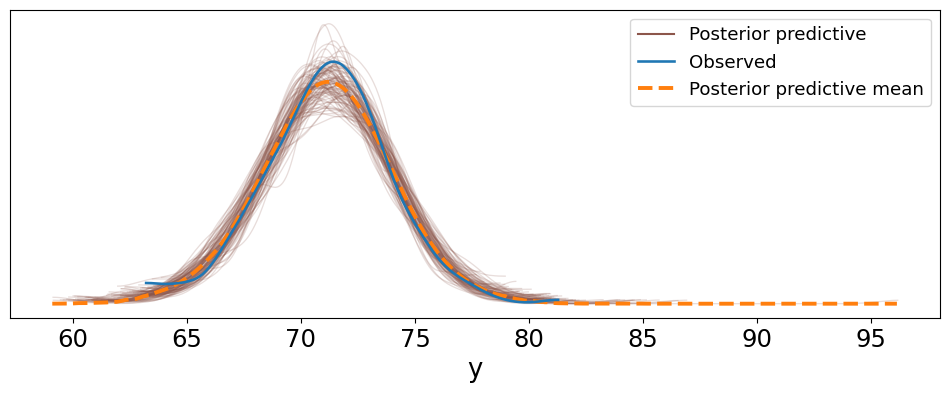

In [ ]:
# posterior predictive sampling (student-t)

pm.sample_posterior_predictive(bat_post2, model=bspeed_model2, extend_inferencedata=True)
az.plot_ppc(bat_post2, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C0", "C1"])

For comparison, here's the posterior of the other model:

Output()

<Axes: xlabel='y'>

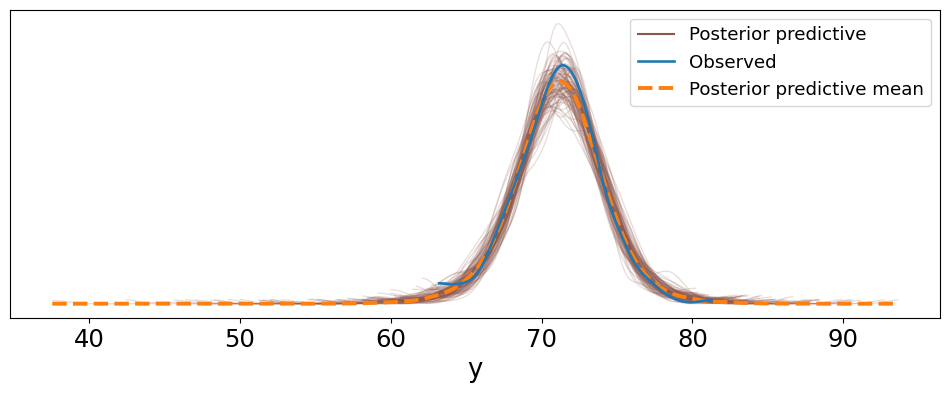

In [ ]:
# posterior predictive sampling (skew student-t)

pm.sample_posterior_predictive(bat_post1, model=bspeed_model1, extend_inferencedata=True)
az.plot_ppc(bat_post1, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C0", "C1"])

I'm gonna be completely honest: both of these fit the data really well and I can't tell much of a difference between the two. Both posteriors fall slightly short of the peak, while fitting the sides of the data very well (especially the right side). If you put a gun to my head and asked me to pick the "better" distribution, I'd go with the skewed student-t, but both of these are really good.

Let's check out the difference in parameters:

array([<Axes: >], dtype=object)

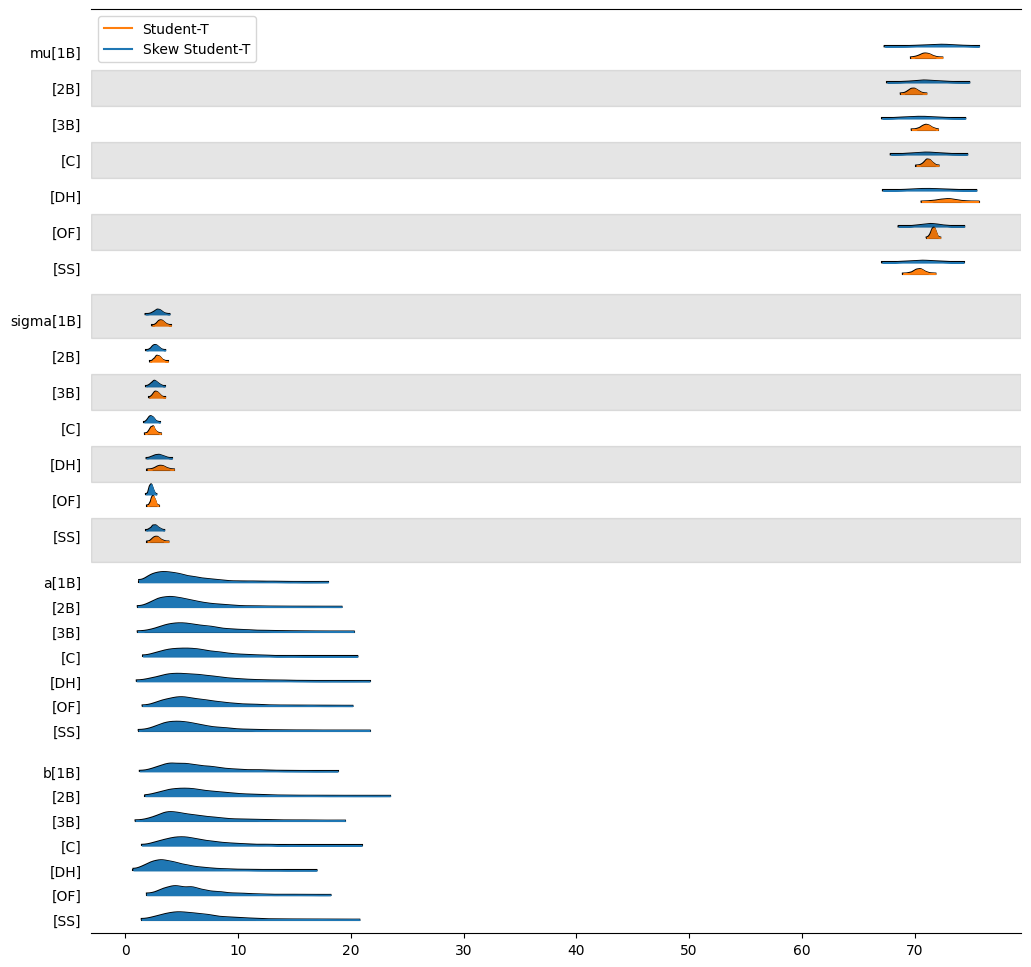

In [24]:
# all parameters

az.plot_forest([bat_post1, bat_post2], var_names = ['mu', 'sigma', 'a', 'b'], combined=True, figsize=(12, 12), kind = 'ridgeplot', hdi_prob=0.997, model_names = ['Skew Student-T', 'Student-T'])
# nu excluded because the scaling makes it unreadable with them added
# a, b are not part of the student-t

Interesting - the difference in means is a lot more pronounced in the regular Student-T than the Skewed Student-T, despite having the exact same prior for both. I'm not sure what's going on there.

This fact inclines me to believe that the Skewed Student-T model is better-suited than the Student-T model. I previously said that I didn't think that the means varied all that much, and I still think that--the fact that the Skewed Student-T modelled the difference in skew (as I thought was notable) while keeping similar means between positions--while the regular student-T got hyper-focused on a specific mean at each position. The overall posterior looks about the same for both, but as stated previously, it's modelled ever so *slightly* better with the skewed-student T.

# Footnotes

<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Or, if you're Shohei Ohtani, you can just be both a full-time pitcher and full-time DH!

<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) To elaborate, I thought this difference in skew is notable--DHs are almost exclusively power hitters, so there will be more hitters that have bat speeds greater than the mode, as they might have to overcompensate for poor baserunning, whereas second basemen are more valued for their defensive prowess, so there will be less pressure to be a power hitter (their builds are different) and so more second basemen will have a lower bat speed than the mode.